ポアソン回帰のサンプル

とある植物１００個から、それぞれ何個の種子が得られるかを予測する
説明変数は それぞれの植物の茎の大きさと肥後処理の有無
目的変数は それぞれの植物からいくつの種が得られたか

In [2]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import mstats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pystan
import arviz

In [12]:
data = pd.read_csv("./input/data3.csv")
data = pd.get_dummies(data)
data.head(10)

,y,x,f_C,f_T
0,6,8.31,1,0
1,6,9.44,1,0
2,6,9.50,1,0
3,12,9.07,1,0
4,10,10.16,1,0
5,4,8.32,1,0
6,9,10.61,1,0
7,9,10.06,1,0
8,9,9.93,1,0
9,11,10.43,1,0


In [24]:
stan_model="""
data {
    int  N;
    real X[N, 2]; // それぞれの茎の大きさと肥後処理の有無
    int  Y[N]; // 観測された種子数はintしかありえない(小数はない)
}

parameters {
    real beta_0; // intercept
    real beta_1; // 茎の大きさの係数
    real beta_2; // 肥後処理の有無の係数
}

transformed parameters {
    real lambda[N];
    for (n in 1:N) {
        lambda[n] = exp(beta_0 + beta_1*X[n,1] + beta_2*X[n,2]); //indexは１から始まるので注意
    }
}

model {
    //for (n in 1:N) {
    //    Y[n] ~ poisson(lambda[n])
    //}
    Y ~ poisson(lambda); // 次元数が一緒なのでOK
}
"""

In [25]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f8135f4ac341bd7726272a900b289190 NOW.


In [28]:
stan_data = {
    "N": data.shape[0],
    "X": data[["x", "f_T"]],
    "Y": data["y"]
}

fit = sm.sampling(data=stan_data, iter=1000, warmup=300, chains=3, seed=0)
print(fit)

Inference for Stan model: anon_model_f8135f4ac341bd7726272a900b289190.
3 chains, each with iter=1000; warmup=300; thin=1; 
post-warmup draws per chain=700, total post-warmup draws=2100.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta_0        1.23    0.01   0.35   0.55   0.98   1.23   1.45   1.94    717   1.01
beta_1        0.08  1.3e-3   0.03   0.01   0.06   0.08   0.11   0.15    699   1.01
beta_2       -0.03  2.7e-3   0.07  -0.18  -0.08  -0.03   0.02   0.11    749   1.01
lambda[1]     6.84    0.02    0.5   5.94   6.51   6.81   7.16   7.91    984   1.01
lambda[2]     7.51    0.01   0.39   6.77   7.25    7.5   7.78   8.28   1437    1.0
lambda[3]     7.55    0.01   0.38   6.81   7.29   7.54   7.82   8.31   1459    1.0
lambda[4]     7.29    0.01   0.41    6.5    7.0   7.28   7.56   8.13   1265    1.0
lambda[5]     7.98    0.01    0.4    7.2   7.69   7.98   8.25   8.74   1406    1.0
lambda[6]     6.85    0.02    0.5   5.95   6.51   6.82   7.17   7.

以上よりGLMでの最尤推定ほぼと同じ結果が得られている(本書参照)

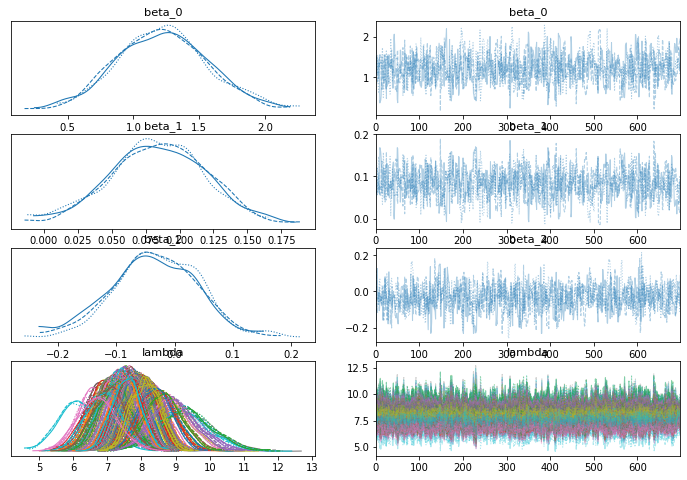

In [29]:
fig = arviz.plot_trace(fit)